<a href="https://colab.research.google.com/github/Bruno-GSilva/price-prediction/blob/main/model_2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2

### Mount Drive to access data

In [380]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Loader

In [382]:
class PriceDataset(Dataset):

  def __init__(self, time_window=30, delta_prev=30, transform=None):

    #Read CSV file
    df = pd.read_csv("/content/drive/MyDrive/data/PETR4.SA.csv", parse_dates=[0], infer_datetime_format=True)
    df_clean = df.dropna().reset_index()

    #Add collumn indicating when there is a time skip > 1 day
    time_skip = [ 0 if index == 0 else 1 if (row['Date'] - df_clean['Date'][index - 1]).days > 1 else 0 for index, row in df_clean.iterrows() ]
    df_clean['Skip dates'] = time_skip

    #Filter usefull collumns
    df_filter = df_clean.filter([ 'Close'])#  'Open', 'High', 'Low', 'Close'])#, 'Skip dates'])
    data = df_filter.values[4000:]

    #Scale input
    #scaler = MinMaxScaler()
    #data = scaler.fit_transform(data)

    #Create samples
    x_samples = []
    y_samples = []
    for i in range (time_window, len(data)-time_window):
      scaler = MinMaxScaler()
      x_data = np.array(data[i-time_window : i])
      scaler.fit(x_data)
      scaled_x = scaler.transform(x_data)
      x_samples.append(scaled_x)
      #y_samples.append([1. if data[i+30,3] > data[i, 3] else 0.])
      #y_samples.append([1. if data[i+30,0] > data[i, 0] else 0.])
      y_sample = data[i+delta_prev]
      y_scaled = scaler.transform(np.reshape(y_sample, (-1,1)))
      y_samples.append(y_scaled)

    
    x_samples, y_samples = np.array(x_samples), np.array(y_samples)

    #Transform int tensors
    self.x_data = torch.from_numpy(x_samples)
    self.y_data = torch.from_numpy(y_samples)
    self.n_data = y_samples.shape[0]

    #Set transform
    self.transform = transform

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
            sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.n_data

## Model

In [383]:
class LSTMPrice1(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice1, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    #out = torch.reshape(output, (output.size(0), -1))
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = F.relu(hn)
    out = F.relu(self.fc_1(out)) #first Dense
    out = self.fc_2(out) #Final Output

    #Output with sigmoid
    #out = torch.sigmoid(out)

    return out      


In [384]:
def train_loop(model, train_loader, num_epochs, criterion, optimizer):
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (inputs, labels) in enumerate(train_loader):  
          if labels.shape[0] == batch_size:
            inputs = inputs.float()
            labels = labels.view(batch_size, 1).float()
            
            # Forward pass
            outputs = model(inputs).float()
            #print(outputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
      print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')
                #print(outputs)

## Trainning 1

In [385]:
dataset = PriceDataset(time_window=60, delta_prev=15)

In [386]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [387]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [388]:
model = LSTMPrice1(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [389]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.7304602861404419
Epoch [2/10], Loss: 1.26108717918396
Epoch [3/10], Loss: 0.09338945895433426
Epoch [4/10], Loss: 0.08997323364019394
Epoch [5/10], Loss: 0.45746350288391113
Epoch [6/10], Loss: 0.09308373928070068
Epoch [7/10], Loss: 0.0859435424208641
Epoch [8/10], Loss: 0.09396772086620331
Epoch [9/10], Loss: 0.03848351165652275
Epoch [10/10], Loss: 0.014894026331603527


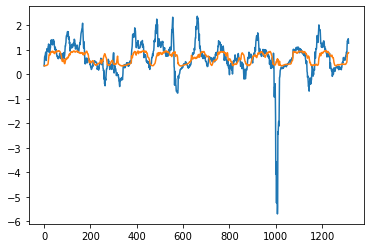

In [390]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Trainning 2

#### 60 days of data | 5 days delta prev | 10 hidden size

In [391]:
dataset = PriceDataset(time_window=60, delta_prev=5)

In [392]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [393]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [394]:
model = LSTMPrice1(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [395]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.4179782271385193
Epoch [2/10], Loss: 0.24265056848526
Epoch [3/10], Loss: 0.05517097935080528
Epoch [4/10], Loss: 0.052180707454681396
Epoch [5/10], Loss: 0.2797330319881439
Epoch [6/10], Loss: 0.1439775675535202
Epoch [7/10], Loss: 0.23105323314666748
Epoch [8/10], Loss: 0.05541856586933136
Epoch [9/10], Loss: 0.05297737941145897
Epoch [10/10], Loss: 0.009599500335752964


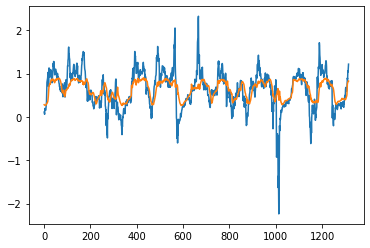

In [396]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Trainning 3

#### 60 days of data | 1 days delta prev | 10 hidden size

In [397]:
dataset = PriceDataset(time_window=60, delta_prev=1)

In [398]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [399]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [400]:
model = LSTMPrice1(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [401]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.11803258210420609
Epoch [2/10], Loss: 0.27773165702819824
Epoch [3/10], Loss: 0.09979823231697083
Epoch [4/10], Loss: 0.016053101047873497
Epoch [5/10], Loss: 0.016360731795430183
Epoch [6/10], Loss: 0.0232721995562315
Epoch [7/10], Loss: 0.06410840153694153
Epoch [8/10], Loss: 0.006718247197568417
Epoch [9/10], Loss: 0.02039187401533127
Epoch [10/10], Loss: 0.02754291333258152


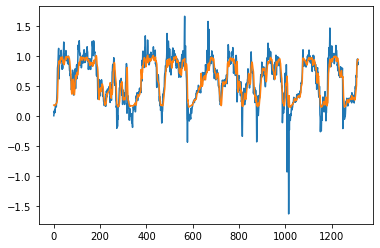

In [402]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

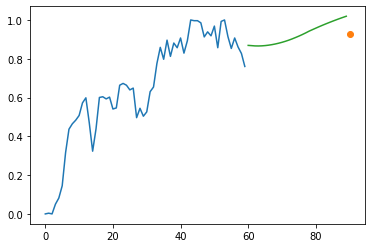

In [403]:
dataset = PriceDataset(time_window=60, delta_prev=30)
initial = dataset[70][0]
correct = dataset[70][1].item()
plt.plot(initial)
plt.plot(90,correct, 'o')
past_month = initial.view(1, -1, 1).float()
prev = []
for i in range(30):
  next_day = model(past_month)
  past_month = torch.cat( (past_month, next_day.view(past_month.size(0), 1, 1)), 1)[:, 1:]
  prev.append(next_day)

plt.plot(range(60,90),prev)

## Trainning 4

#### 90 days of data | 5 days delta prev | 10 hidden size

In [404]:
dataset = PriceDataset(time_window=90, delta_prev=5)

In [405]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [406]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [407]:
model = LSTMPrice1(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [408]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.13902992010116577
Epoch [2/10], Loss: 0.020974745973944664
Epoch [3/10], Loss: 0.02716854028403759
Epoch [4/10], Loss: 1.4644798040390015
Epoch [5/10], Loss: 0.04939302057027817
Epoch [6/10], Loss: 0.05053839832544327
Epoch [7/10], Loss: 0.011710877530276775
Epoch [8/10], Loss: 0.016861895099282265
Epoch [9/10], Loss: 1.05538010597229
Epoch [10/10], Loss: 0.02640172280371189


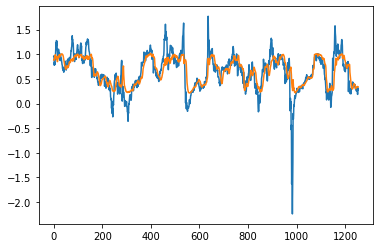

In [409]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Modified Model

In [410]:
class LSTMPrice2(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice2, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    for i in range(self.seq_length):
      h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
      c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
      # Propagate input through LSTM
      output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
      #out = torch.reshape(output, (output.size(0), -1))
      hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
      out = F.relu(hn)
      out = F.relu(self.fc_1(out)) #first Dense
      out = self.fc_2(out) #Final Output


      #Output with sigmoid
      #out = torch.sigmoid(out)
      
      x = torch.cat( (x,out.view(x.size(0), 1, 1)), 1)[:, 1:]

    return out      


## Trainning 1

In [411]:
delta_prev=15
dataset = PriceDataset(time_window=60, delta_prev=delta_prev)

In [412]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [413]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [414]:
model = LSTMPrice2(num_classes, input_size, hidden_size, num_layers, seq_length=delta_prev)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [415]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.07071970403194427
Epoch [2/10], Loss: 0.20310360193252563
Epoch [3/10], Loss: 0.17660516500473022
Epoch [4/10], Loss: 0.32605329155921936
Epoch [5/10], Loss: 0.48376625776290894
Epoch [6/10], Loss: 0.07301172614097595
Epoch [7/10], Loss: 0.10502579808235168
Epoch [8/10], Loss: 0.2148156315088272
Epoch [9/10], Loss: 0.09957566857337952
Epoch [10/10], Loss: 0.6257641911506653


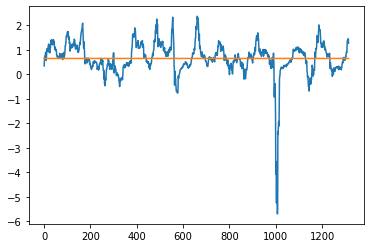

In [416]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Trainning 2

#### 60 days of data | 5 days delta prev | 10 hidden size

In [417]:
delta_prev=5
dataset = PriceDataset(time_window=60, delta_prev=delta_prev)

In [418]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [419]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [420]:
model = LSTMPrice2(num_classes, input_size, hidden_size, num_layers, seq_length=delta_prev)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [421]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.14442285895347595
Epoch [2/10], Loss: 0.13579963147640228
Epoch [3/10], Loss: 0.11268071085214615
Epoch [4/10], Loss: 0.12104210257530212
Epoch [5/10], Loss: 0.07211177051067352
Epoch [6/10], Loss: 0.012282713316380978
Epoch [7/10], Loss: 0.015004079788923264
Epoch [8/10], Loss: 0.023055927827954292
Epoch [9/10], Loss: 0.11578309535980225
Epoch [10/10], Loss: 0.08121393620967865


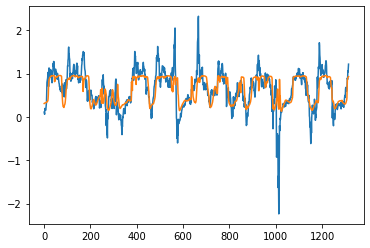

In [422]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Trainning 3

#### 60 days of data | 1 days delta prev | 10 hidden size

In [423]:
dataset = PriceDataset(time_window=60, delta_prev=1)

In [424]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [425]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [426]:
model = LSTMPrice1(num_classes, input_size, hidden_size, num_layers, seq_length=1)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [427]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.02947615459561348
Epoch [2/10], Loss: 0.09830450266599655
Epoch [3/10], Loss: 0.07175467163324356
Epoch [4/10], Loss: 0.12205953896045685
Epoch [5/10], Loss: 0.016788262873888016
Epoch [6/10], Loss: 0.02162931114435196
Epoch [7/10], Loss: 0.003755914978682995
Epoch [8/10], Loss: 0.07171241194009781
Epoch [9/10], Loss: 0.011646374128758907
Epoch [10/10], Loss: 0.0033610030077397823


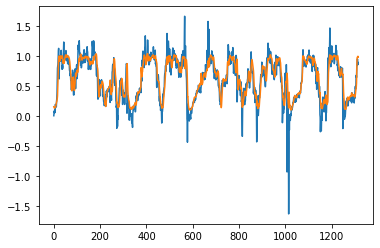

In [428]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

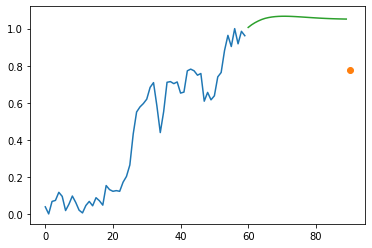

In [434]:
dataset = PriceDataset(time_window=60, delta_prev=30)
initial = dataset[50][0]
correct = dataset[50][1].item()
plt.plot(initial)
plt.plot(90,correct, 'o')
past_month = initial.view(1, -1, 1).float()
prev = []
for i in range(30):
  next_day = model(past_month)
  past_month = torch.cat( (past_month, next_day.view(past_month.size(0), 1, 1)), 1)[:, 1:]
  prev.append(next_day)

plt.plot(range(60,90),prev)

## Trainning 4

#### 90 days of data | 5 days delta prev | 10 hidden size

In [310]:
delta_prev=5
dataset = PriceDataset(time_window=90, delta_prev=delta_prev)

In [311]:
#Hyperparameters
batch_size=4
learning_rate=0.0001
input_size=dataset[0][0].shape[1]
seq_length = dataset[0][0].shape[0]
hidden_size=10
num_epochs=10
num_layers=1
num_classes=dataset[0][1].shape[0]

In [312]:
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

In [313]:
model = LSTMPrice2(num_classes, input_size, hidden_size, num_layers, seq_length=delta_prev)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

example_input = dataset[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [314]:
train_loop(model, train_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Loss: 0.2381274402141571
Epoch [2/10], Loss: 0.07060571759939194
Epoch [3/10], Loss: 0.07708024978637695
Epoch [4/10], Loss: 0.006979550234973431
Epoch [5/10], Loss: 0.05107253044843674
Epoch [6/10], Loss: 0.05459846183657646
Epoch [7/10], Loss: 0.020827392116189003
Epoch [8/10], Loss: 0.10505160689353943
Epoch [9/10], Loss: 0.060645099729299545
Epoch [10/10], Loss: 0.12035351991653442


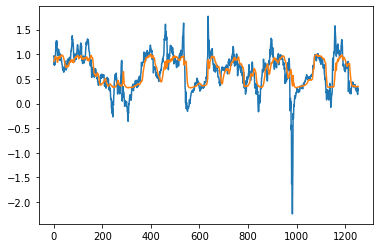

In [315]:
with torch.no_grad():
  prev = []
  close = []
  for input, output in dataset:
    close.append(output.view(-1,).item())
    prev.append(model(input.view(1, seq_length, 1).float()).view(-1,).item())
  plt.plot(close, label="close")
  plt.plot(prev, label="prev")

## Model 3

In [429]:
class LSTMPrice3(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice3, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size*seq_length, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    #for i in range(self.seq_length):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    out = torch.reshape(output, (output.size(0), -1))
    #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = F.relu(out)
    out = F.relu(self.fc_1(out)) #first Dense
    out = self.fc_2(out) #Final Output


    #Output with sigmoid
    #out = torch.sigmoid(out)
      
      #x = torch.cat( (x,out.view(x.size(0), 1, 1)), 1)[:, 1:]

    return out      
